In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pickle as pkl
import tensorflow as tf
import metrics

import warnings
warnings.filterwarnings('once')

In [2]:
mape = metrics.build_mape(overlap=6)
smape = metrics.build_smape(overlap=6)
mase_estimate = metrics.build_mase(overlap=6)
owa_estimate = metrics.build_owa(overlap=6)
reconstruction_loss = metrics.build_reconstruction_loss(overlap=6)

In [3]:
def MASE(x, y, p):
    nom = np.mean(np.abs(y - p), axis=1)
    denom = np.mean(np.abs(x[:, 1:] - x[:, :-1]), axis=1) + np.finfo('float').eps
    return nom / denom

def SMAPE(y, p):
    nom = np.abs(y - p)
    denom = np.abs(y) + np.abs(p) + np.finfo('float').eps
    return 2 * np.mean(nom / denom, axis=1) * 100

def OWA(x, y, p):
    rel_smape = SMAPE(y, p) / 15.201
    rel_mase = MASE(x, y, p) / 1.685
    return (rel_smape + rel_mase) / 2

In [4]:
train_path = Path('../M4-methods/Dataset/Train/Yearly-train.csv')
test_path = Path('../M4-methods/Dataset/Test/Yearly-test.csv')

In [5]:
train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [6]:
def get_last_12(series):
    return series.dropna().iloc[-12:].values

In [7]:
X_test = np.array([get_last_12(ser[1]) for ser in train.iterrows()])
y_test = test.values

In [8]:
def get_predictions(model, X):
    
    preds = []
    
    for i in range(len(X) // 256):
        x = X[i * 256:(i+1) * 256]

        mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1) 
        x_sc = (x - mn) / (mx - mn)
        pred = model(x_sc[..., np.newaxis]) 
        preds.append(pred[..., 0] * (mx - mn) + mn)

    x = X[(i+1) * 256:]
    mn, mx = x.min(axis=1).reshape(-1, 1), x.max(axis=1).reshape(-1, 1) 
    x_sc = (x - mn) / (mx - mn)
    pred = model(x_sc[..., np.newaxis]) 
    preds.append(pred[..., 0] * (mx - mn) + mn)

    return np.vstack(preds)

In [9]:
results = {'smape': {k: [] for k in range(12)},
           'mase': {k: [] for k in range(12)},
           'owa': {k: [] for k in range(12)}}

for i in range(12):
    model_dir = 'results/' + str(i) + '/best_weights.h5'

    model = tf.keras.models.load_model(model_dir, custom_objects={'SMAPE': smape,
                                                                  'MASE_estimate': mase_estimate,
                                                                  'OWA_estimate': owa_estimate,
                                                                  'reconstruction_loss': reconstruction_loss})
    
    preds = get_predictions(model, X_test)
    
    results['smape'][i].append(np.nanmean(SMAPE(y_test, preds[:, 6:])))
    results['mase'][i].append(np.nanmean(MASE(X_test, y_test, preds[:, 6:])))
    results['owa'][i].append(np.nanmean(OWA(X_test, y_test, preds[:, 6:])))

/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/thanos/.envs/fsu/lib/p

In [10]:
results

{'smape': {0: [13.307012008856603],
  1: [13.312890132023561],
  2: [13.412372811814334],
  3: [13.448974783492273],
  4: [13.600577810297244],
  5: [13.462200834565762],
  6: [13.479048722286926],
  7: [13.474238634632872],
  8: [13.436619184876152],
  9: [13.211644733815417],
  10: [13.412307646974234],
  11: [13.341309835606527]},
 'mase': {0: [2.5100305402060012],
  1: [2.48067277779466],
  2: [2.4940301072348428],
  3: [2.4947787603959],
  4: [2.599860932934271],
  5: [2.5526864456959415],
  6: [2.5494623668666927],
  7: [2.5602966634769895],
  8: [2.5510840518170332],
  9: [2.470802343828664],
  10: [2.533969710325493],
  11: [2.513098226603675]},
 'owa': {0: [1.182518046048329],
  1: [1.17399989044365],
  2: [1.181235730977093],
  3: [1.1826618162705318],
  4: [1.2188300834472803],
  5: [1.2002801445256182],
  6: [1.1998776149506418],
  7: [1.202934323602209],
  8: [1.1989632104515036],
  9: [1.1677407566505662],
  10: [1.1930851018080646],
  11: [1.1845564825131458]}}

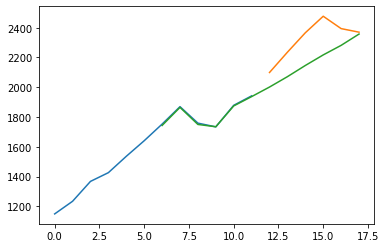

In [47]:
i = 150
plt.plot(range(12), X_test[i])
plt.plot(range(12, 18), y_test[i])
plt.plot(range(6, 18), preds[i])

---

### Investigate bad performance

In [12]:
model

In [13]:
X = train.iloc[2].dropna().values

In [14]:
def norm(ser):
    x = ser[:12]
    y = ser[12:]
    mn = x.min()
    mx = x.max()
    x_sc = (x - mn) / (mx - mn)
    y_sc = (y - mn) / (mx - mn)
    return x_sc[np.newaxis, ..., np.newaxis], y_sc, mn, mx

In [15]:
x, y, mn, mx = norm(X[:18])
p = model(x)

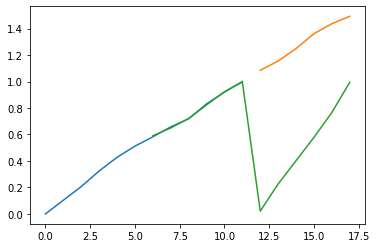

In [16]:
plt.plot(range(12), x[0, :, 0])
plt.plot(range(12, 18), y)
plt.plot(range(6, 18), p[0, :, 0])

In [18]:
x = np.array([0.8559322 , 0.28813559, 0.56779661, 1.        , 0.81355932,
              0.3559322 , 0.44067797, 0.27118644, 0.5       , 0.31355932,
              0.        , 0.01694915])

In [ ]:
p = model(x)
plt.plot(range(12), x[0, :, 0])
plt.plot(range(6, 18), p[0, :, 0])